In [42]:
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
import tensorflow as tf

from keras import layers
from keras.metrics import Precision, Recall, F1Score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Adamax, Ftrl
from keras.datasets import fashion_mnist
from keras.callbacks import History, Callback

In [43]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.clf()
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

In [44]:
def plot_precision_recall(history):
    precision_values = [history.history[f'precision_class_{i}'][-1] for i in range(10)]
    recall_values = [history.history[f'recall_class_{i}'][-1] for i in range(10)]

    classes = [str(i) for i in range(10)]
    width = 0.35
    x = range(len(classes))

    plt.figure(figsize=(12, 6))

    plt.bar(x, precision_values, width, label='Precision')
    plt.bar([i + width for i in x], recall_values, width, label='Recall')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Precision and Recall for Each Class')
    plt.xticks([i + width/2 for i in x], classes)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.grid(axis='y', linestyle='--')

    plt.show()

In [45]:
clothing_classes = 10
n_hidden_1 = 64
n_hidden_2 = 128
n_hidden_3 = 256
epochs = 10

In [46]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

train_data, test_data = train_data / 255., test_data / 255.

train_labels_one_hot = to_categorical(train_labels, num_classes=clothing_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes=clothing_classes)

In [47]:
precision_per_class = [Precision(class_id=i, name=f'precision_class_{i}') for i in range(clothing_classes)]
recall_per_class = [Recall(class_id=i, name=f'recall_class_{i}') for i in range(clothing_classes)]

all_metrics = ['accuracy'] + precision_per_class + recall_per_class

In [48]:
class MyFilterModelMP(keras_tuner.HyperModel):
  def build(self, hp):
    model = Sequential([
      Conv2D(
          filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
          kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
          activation='relu',
          input_shape=(28,28,1)
      ),
      MaxPooling2D((2, 2)),
      Conv2D(
          filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
          kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
          activation='relu'
      ),
      Flatten(),
      Dense(
          units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
          activation='relu'
      ),
      Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='categorical_crossentropy',
                metrics=all_metrics)

    return model

  def fit(self, hp, model, x, y, validation_data, **kwargs):
    if hp.Boolean("normalize"):
      x = layers.Normalization()(x)
    return model.fit(
      x,
      y,
      validation_data=validation_data,
      shuffle=hp.Boolean("shuffle"),
      **kwargs,)

In [49]:
tuner = keras_tuner.RandomSearch(
    MyFilterModelMP(),
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
)

In [50]:
tuner.search(train_data,
             train_labels_one_hot,
             epochs=5,
             validation_data=(test_data, test_labels_one_hot),
             batch_size=32)

Trial 5 Complete [00h 01m 36s]
val_accuracy: 0.9104999899864197

Best val_accuracy So Far: 0.9110999703407288
Total elapsed time: 00h 10m 24s


In [51]:
filtermodel = MyFilterModelMP()
best_hp = tuner.get_best_hyperparameters()[0]
model_filter_ = filtermodel.build(best_hp)
history = filtermodel.fit(best_hp,
                        model_filter_,
                        train_data,
                        train_labels_one_hot,
                        validation_data=(test_data, test_labels_one_hot),
                        epochs=10,
                        batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 35s 18ms/step - loss: 0.4408 - accuracy: 0.8422 - precision_class_0: 0.8226 - precision_class_1: 0.9791 - precision_class_2: 0.8283 - precision_class_3: 0.8943 - precision_class_4: 0.7817 - precision_class_5: 0.9625 - precision_class_6: 0.7329 - precision_class_7: 0.9246 - precision_class_8: 0.9723 - precision_class_9: 0.9460 - recall_class_0: 0.7850 - recall_class_1: 0.9506 - recall_class_2: 0.6910 - recall_class_3: 0.8327 - recall_class_4: 0.7291 - recall_class_5: 0.9274 - recall_class_6: 0.4709 - recall_class_7: 0.9143 - recall_class_8: 0.9290 - recall_class_9: 0.9414 - val_loss: 0.3450 - val_accuracy: 0.8780 - val_precision_class_0: 0.8788 - val_precision_class_1: 0.9779 - val_precision_class_2: 0.7515 - val_precision_class_3: 0.8953 - val_precision_class_4: 0.8540 - val_precision_class_5: 0.9853 - val_precision_class_6: 0.7968 - val_precision_class_7: 0.9182 - val_precision_class_8: 0.9699 - val_precision_class_9: 0.9530 - va

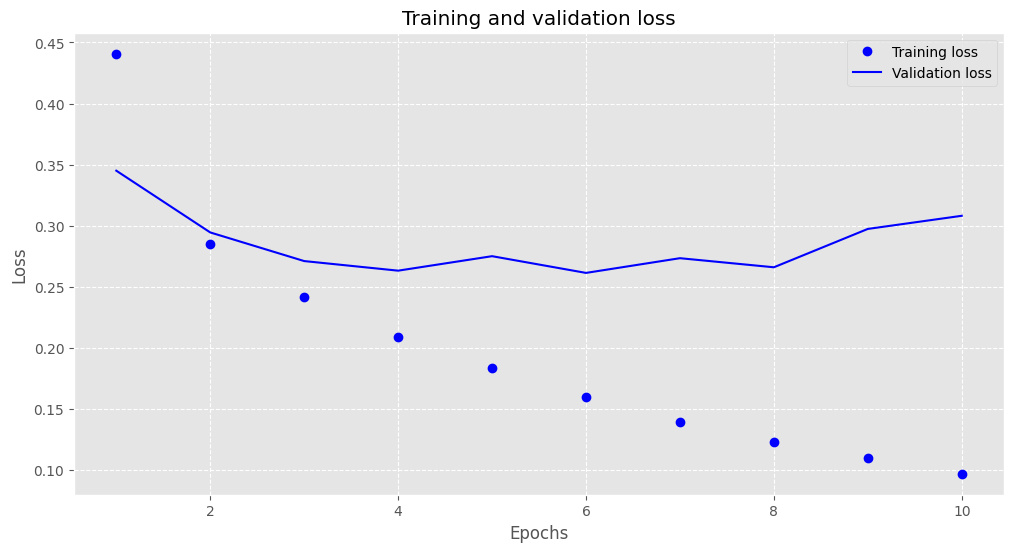

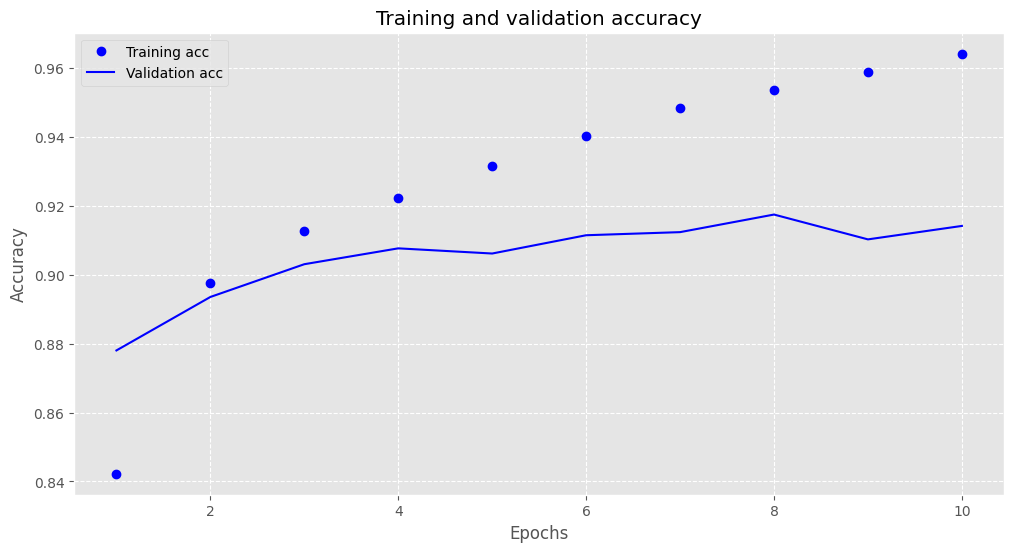

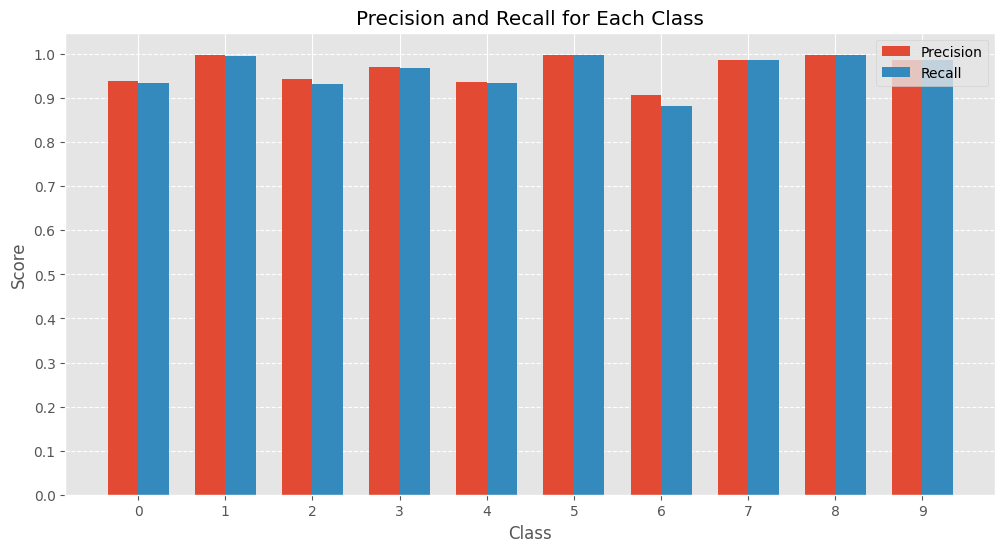

In [52]:
plot_history(history)
plot_precision_recall(history)

In [59]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.1,
)

train_generator = datagen.flow(train_data.reshape(-1, 28, 28, 1), train_labels_one_hot, batch_size=32)

In [60]:
filtermodel = MyFilterModelMP()
best_hp = tuner.get_best_hyperparameters()[0]
model_filter = filtermodel.build(best_hp)
history = model_filter.fit(
    train_generator,
    steps_per_epoch=100,
    validation_data=(test_data.reshape(-1, 28, 28, 1), test_labels_one_hot),
    validation_steps=50,
    epochs=100,
    batch_size=32
)

Epoch 1/100
100/100 [==============================] - 5s 31ms/step - loss: 1.1572 - accuracy: 0.5672 - precision_class_0: 0.7849 - precision_class_1: 0.9430 - precision_class_2: 0.6463 - precision_class_3: 0.8191 - precision_class_4: 0.7366 - precision_class_5: 0.8910 - precision_class_6: 0.5488 - precision_class_7: 0.8417 - precision_class_8: 0.9489 - precision_class_9: 0.9000 - recall_class_0: 0.4551 - recall_class_1: 0.7429 - recall_class_2: 0.3696 - recall_class_3: 0.5253 - recall_class_4: 0.3580 - recall_class_5: 0.6957 - recall_class_6: 0.2428 - recall_class_7: 0.7204 - recall_class_8: 0.7439 - recall_class_9: 0.8364 - val_loss: 0.7924 - val_accuracy: 0.6931 - val_precision_class_0: 0.8553 - val_precision_class_1: 0.9085 - val_precision_class_2: 0.4716 - val_precision_class_3: 0.7907 - val_precision_class_4: 0.0000e+00 - val_precision_class_5: 0.8924 - val_precision_class_6: 0.0000e+00 - val_precision_class_7: 0.7921 - val_precision_class_8: 0.9752 - val_precision_class_9: 0.990

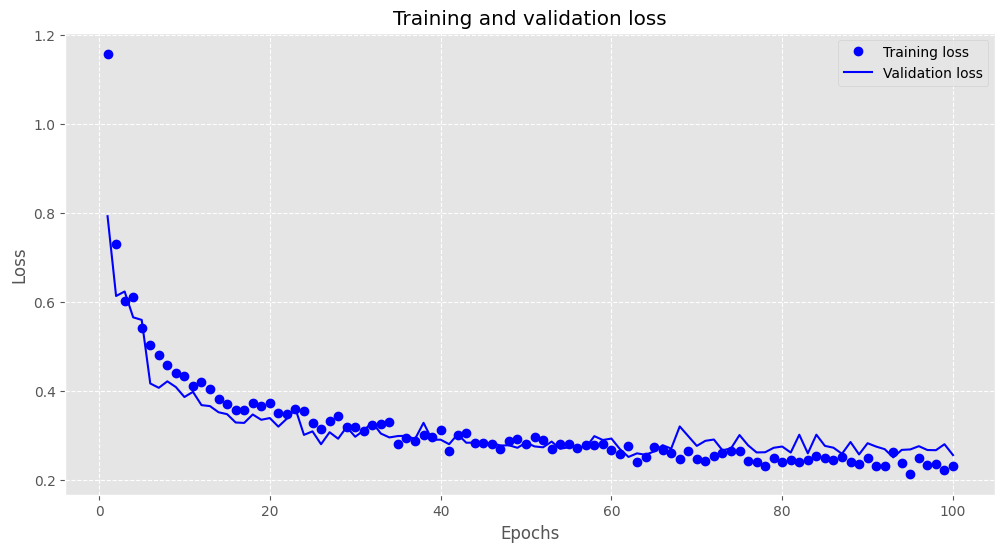

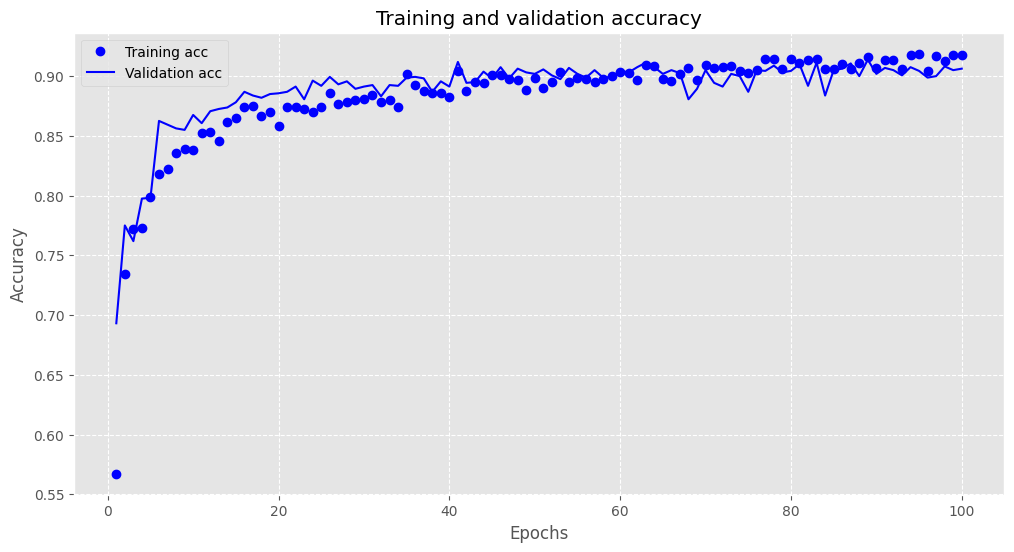

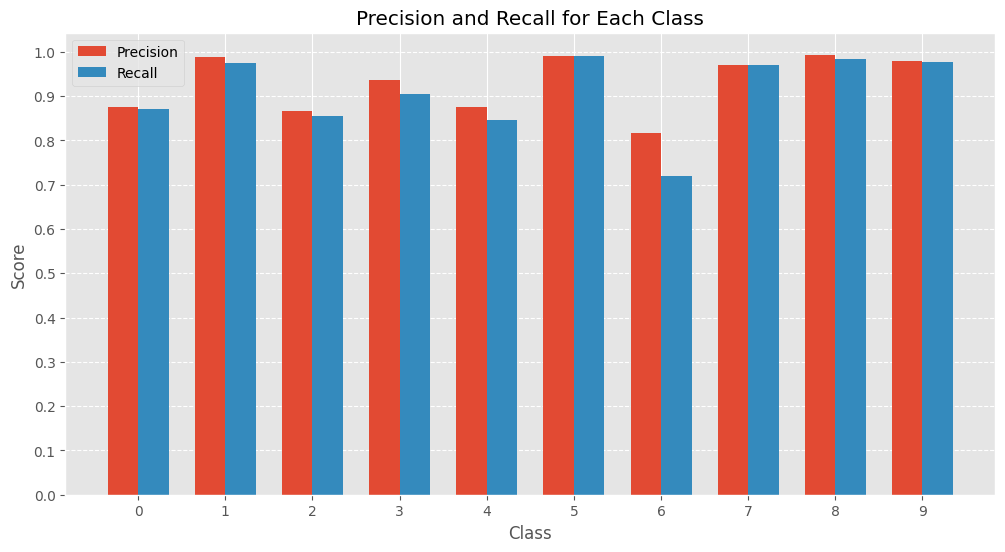

In [61]:
plot_history(history)
plot_precision_recall(history)